### Configuração inicial

In [1]:
import sys
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib 

#eprodutibilidade (SEED)
# Isso garante que os resultados sejam sempre iguais, eliminando o fator sorte.
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(SEED) # Trava o TensorFlow

# Configurações para forçar determinismo (opcional, mas recomendado)
tf.config.experimental.enable_op_determinism()

# Atalhos do Keras
Sequential = keras.models.Sequential
LSTM = keras.layers.LSTM
Dense = keras.layers.Dense
Dropout = keras.layers.Dropout
EarlyStopping = keras.callbacks.EarlyStopping

# Configuração visual e hardware
sns.set_style('darkgrid')
print(f"Versão do TensorFlow: {tf.__version__}")

# Forçar CPU (Conforme nossa decisão anterior)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(" Configuração concluída. Seed fixado em 42.")

2025-12-13 15:12:35.238879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-13 15:12:35.239080: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 15:12:35.265032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Versão do TensorFlow: 2.20.0
 Configuração concluída. Seed fixado em 42.


2025-12-13 15:12:35.853252: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 15:12:35.853415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


### Carregamento e Visualização Inicial

✅ Dados limpos! 1737 registros carregados.


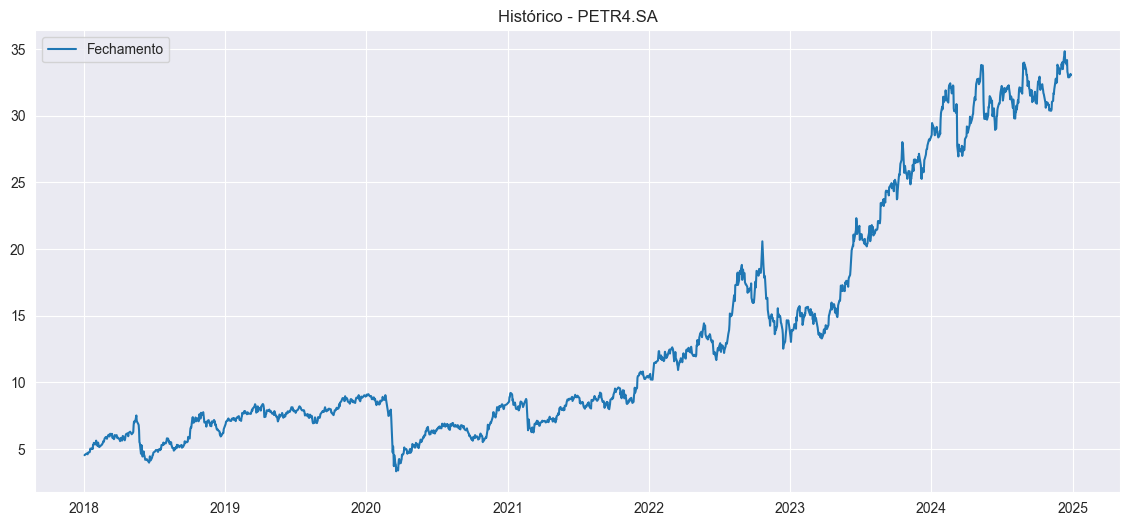

In [2]:
# Célula 2: Carregamento e Tratamento de Tipos
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Silenciar avisos chatos do Pandas
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

SYMBOL = 'PETR4.SA'

try:
    # 1. Carregar sem assumir index
    df = pd.read_csv(f'../data/{SYMBOL}.csv')
    
    # 2. Renomear colunas
    if 'Date' not in df.columns:
        df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
    
    col_close = [c for c in df.columns if 'Close' in c]
    if col_close:
        df.rename(columns={col_close[0]: 'Close'}, inplace=True)

    # 3. Conversão de tipos (Com avisos silenciados)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    
    # 4. Limpeza e Index
    df = df.dropna(subset=['Date', 'Close'])
    df = df.set_index('Date')
    
    print(f"✅ Dados limpos! {len(df)} registros carregados.")
    
    # 5. Visualizar
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Close'], label='Fechamento')
    plt.title(f'Histórico - {SYMBOL}')
    plt.legend()
    plt.show()

    data = df[['Close']].values

except Exception as e:
    print(f"Erro: {e}")

### Divisão: 
Não pode ser aleatória (train_test_split simples). 
Tem que ser cronológica. Treinamos com o passado, testamos com o futuro.
### Data Leakage: 
O Scaler só pode "aprender" (fit) com os dados de treino. Se fizermos fit no dataset todo, o modelo "espia" o futuro.

In [3]:
# 1. Divisão Cronológica (80% Treino, 20% Teste)
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

print(f"Dados de Treino: {len(train_data)} dias")
print(f"Dados de Teste: {len(test_data)} dias")

# 2. Normalização (Escala 0 a 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# IMPORTANTE: Fit apenas no treino!
scaled_train = scaler.fit_transform(train_data)
# Transform no teste (usando a escala aprendida no treino)
scaled_test = scaler.transform(test_data)

Dados de Treino: 1389 dias
Dados de Teste: 348 dias


### Criando as Sequências (Sliding Window)
**LSTMs** precisam de dados 3D: [Amostras, Passos de Tempo, Features]. 
Vamos criar uma função que pega os últimos 60 dias (janela) para prever o dia seguinte.

In [4]:
def create_sequences(dataset, window_size=60):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, 0]) # Os 60 dias anteriores
        y.append(dataset[i, 0])               # O dia atual (alvo)
    return np.array(X), np.array(y)

WINDOW_SIZE = 60

# Criar sequências
X_train, y_train = create_sequences(scaled_train, WINDOW_SIZE)
X_test, y_test = create_sequences(scaled_test, WINDOW_SIZE)

# Reshape para formato LSTM [Amostras, Time Steps, Features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Shape X_train: {X_train.shape}") # Deve ser (N, 60, 1)

Shape X_train: (1329, 60, 1)


### Construção e Treinamento do Modelo
- **LSTM** com Camadas recorrentes para memória de longo prazo.
- **Dropout** para Desliga 20% dos neurônios aleatoriamente para evitar decorar os dados ou (famigerado **overfitting**)
- Usando **EarlyStopping** caso o modelo pare de melhorar, o treinamento para sozinho.

2025-12-13 15:12:36.065327: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-13 15:12:36.065351: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-12-13 15:12:36.065354: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-12-13 15:12:36.065356: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-13 15:12:36.065358: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: devdell
2025-12-13 15:12:36.065360: I external/local_xla/xla/stream_executor/cuda/cuda_

Epoch 1/50


2025-12-13 15:12:36.149145: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0217 - val_loss: 0.0273
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0097
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 0.0190
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - val_loss: 0.0099
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_l

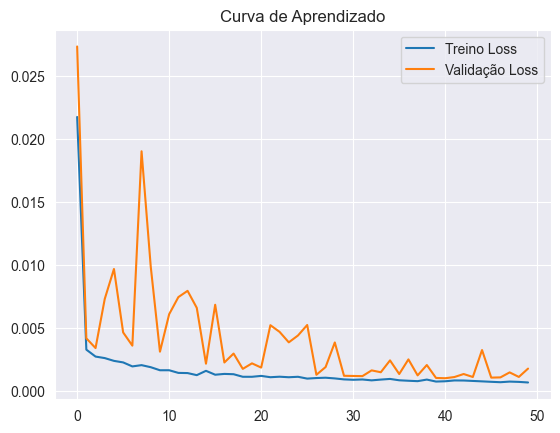

In [5]:
# Arquitetura do Modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1) # Saída: Preço previsto
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Callback para parar cedo se não melhorar
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50, # Pode aumentar se precisar, mas EarlyStopping vai segurar
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Plotar curva de aprendizado
plt.plot(history.history['loss'], label='Treino Loss')
plt.plot(history.history['val_loss'], label='Validação Loss')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

### Avaliação e Métricas de Negócio
Transformando os números de volta para Reais (R$) e calculando o erro...

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

--- Resultados Finais ---
MAE (Erro Médio Absoluto): R$ 0.45
RMSE (Raiz do Erro Quadrático): R$ 0.61
MAPE (Erro Percentual): 1.49%


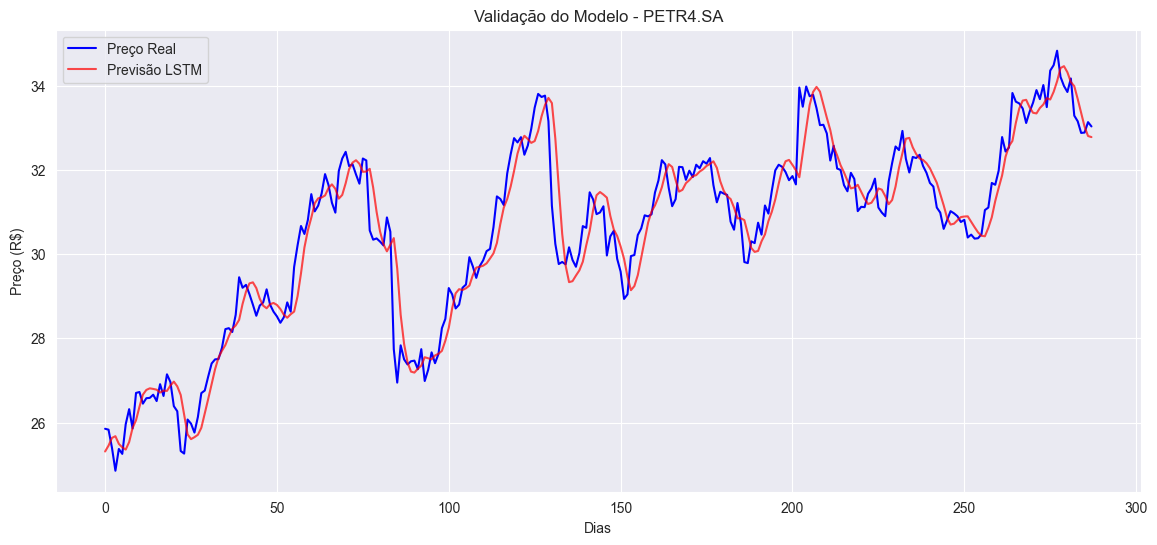

In [6]:
# Fazer previsões
predictions = model.predict(X_test)

# Inverter a escala (voltar para R$)
predictions_real = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular Métricas
mae = mean_absolute_error(y_test_real, predictions_real)
rmse = np.sqrt(mean_squared_error(y_test_real, predictions_real))
mape = np.mean(np.abs((y_test_real - predictions_real) / y_test_real)) * 100

print(f"\n--- Resultados Finais ---")
print(f"MAE (Erro Médio Absoluto): R$ {mae:.2f}")
print(f"RMSE (Raiz do Erro Quadrático): R$ {rmse:.2f}")
print(f"MAPE (Erro Percentual): {mape:.2f}%")

# Gráfico Final (Real vs Predito)
plt.figure(figsize=(14, 6))
plt.plot(y_test_real, label='Preço Real', color='blue')
plt.plot(predictions_real, label='Previsão LSTM', color='red', alpha=0.7)
plt.title(f'Validação do Modelo - {SYMBOL}')
plt.xlabel('Dias')
plt.ylabel('Preço (R$)')
plt.legend()
plt.show()

### Salvar Artefatos para Produção
**Importante** Isso é vital para a API. Se não salvarmos o scaler, a API não saberá transformar os dados novos.

In [7]:
import os

# Criar pasta models se não existir
os.makedirs('../models', exist_ok=True)

# Salvar Modelo
model.save('../models/lstm_model.keras')
print("Modelo salvo em models/lstm_model.keras")

# Salvar Scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("Scaler salvo em models/scaler.pkl")

Modelo salvo em models/lstm_model.keras
Scaler salvo em models/scaler.pkl
